# MNIST Digit Classification

### Import libraries

In [1]:
""" MNIST Digit Classification """

print("Import libraries")
import tensorflow as tf
import numpy as np
import pandas as pd
import os
from numpy.random import seed
from tensorflow.keras.layers import MaxPool2D, Conv2D, Flatten, Dense, BatchNormalization, ReLU
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

""" check libraries' versions """
print("Tensorflow version", tf.__version__)
print("Numpy version", np.__version__)

#set constant seed
print("Set constant random seed")
seed(1)
tf.random.set_seed(1)

Import libraries
Tensorflow version 2.2.0
Numpy version 1.18.4
Set constant random seed


In [0]:
#set constant seed
seed(1)
tf.random.set_seed(1)

#parameters
epochs = 200
batch_size = 32

In [3]:
from tensorflow.keras.datasets import mnist
(image_train, label_train), _ = mnist.load_data()

#reshape
image_train = image_train.reshape(-1, 28, 28, 1)
print("Original image shape", image_train.shape)
x_train, _, y_train, _ = train_test_split(image_train, label_train, test_size = 0.9, shuffle = True, random_state = 10)
print("Original image shape", image_train.shape)
print("Train_image shape", x_train.shape)
_, x_test, _, y_test = train_test_split(x_train, y_train, test_size = 0.3, shuffle = True, random_state = 1)
print("x_train shape", x_train.shape)
print("y_train shape", x_test.shape)

11493376/11490434 [==============================] - 0s 0us/step
Original image shape (60000, 28, 28, 1)
Original image shape (60000, 28, 28, 1)
Train_image shape (6000, 28, 28, 1)
x_train shape (6000, 28, 28, 1)
y_train shape (1800, 28, 28, 1)


### Investigate data

In [6]:
#investigate data
print("Investigate data")

print("x_train shape:", x_train.shape)
print("y_train shape", y_train.shape)

print("Check shape of images")
print("Image shape", x_train[0].shape)

Investigate data
x_train shape: (6000, 28, 28, 1)
y_train shape (6000,)
Check shape of images
Image shape (28, 28, 1)


Inspect the labels' balance


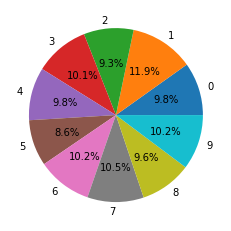

In [7]:
print("Inspect the labels' balance")
labels, occurences = np.unique(y_train, return_counts = True)
plt.pie(occurences, labels = labels, autopct='%1.1f%%')
plt.show()

Print image


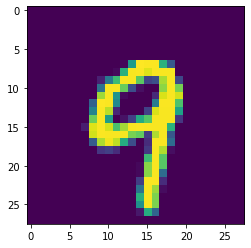

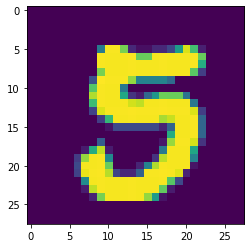

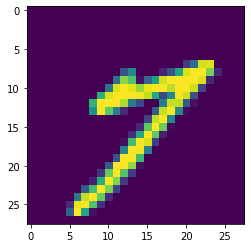

In [8]:
print("Print image")
indices = np.random.randint(0, x_train.shape[0], size = 3)
printing_images = x_train[indices]
printing_images = [x.reshape(28,28) for x in printing_images]

#show images
plt.imshow(printing_images[0])
plt.show()
plt.imshow(printing_images[1])
plt.show()
plt.imshow(printing_images[2])
plt.show()

### Build data generator       

In [9]:
print("Build data_generator by ImageDataGenerator")
train_image_gen = ImageDataGenerator(width_shift_range = 0.2, height_shift_range = 0.2, rotation_range = 10, brightness_range = (0.2, 0.8), rescale = 1./255.0)
eval_image_gen = ImageDataGenerator(rescale=1./255.0)
test_image_gen = ImageDataGenerator(rescale=1./255.)

print("Generate evaluation data")
_, x_eval, _, y_eval = train_test_split(x_train, y_train, test_size = 0.3, shuffle = True, random_state = 1)

train_image_gen.fit(x_train)
train_gen = train_image_gen.flow(x_train, y_train, batch_size = batch_size)
eval_image_gen.fit(x_eval)
eval_gen = eval_image_gen.flow(x_eval, y_eval, batch_size = batch_size)

print("train_gen", train_gen.__len__())
print("test_gen", eval_gen.__len__())

Build data_generator by ImageDataGenerator
Generate evaluation data
train_gen 188
test_gen 57


### Build CNN model

In [10]:
def create_model(name = 'CNN'):
    model = Sequential(name = name)

    model.add(MaxPool2D(4,4, input_shape = (28,28,1)))
    model.add(Conv2D(28, kernel_size = 3, padding = 'same'))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(Conv2D(28, kernel_size = 3, padding = 'same'))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(MaxPool2D(2,1, padding = 'same'))

    model.add(Conv2D(14, kernel_size = 5, padding = 'same'))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(Conv2D(14, kernel_size = 5, padding = 'same'))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(MaxPool2D(2,2))

    model.add(Flatten())
    model.add(Dense(512, activation = 'relu', kernel_regularizer = l2(0.01)))
    model.add(Dense(256, activation = 'relu', kernel_regularizer = l2(0.01)))
    model.add(Dense(10, activation = 'softmax'))
    model.compile(optimizer = Adam(learning_rate= 0.001), loss = 'sparse_categorical_crossentropy', metrics =['accuracy'])
    print(model.summary())
    return model
model = create_model(name = 'Conv_model')

Model: "Conv_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
max_pooling2d (MaxPooling2D) (None, 7, 7, 1)           0         
_________________________________________________________________
conv2d (Conv2D)              (None, 7, 7, 28)          280       
_________________________________________________________________
batch_normalization (BatchNo (None, 7, 7, 28)          112       
_________________________________________________________________
re_lu (ReLU)                 (None, 7, 7, 28)          0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 28)          7084      
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 28)          112       
_________________________________________________________________
re_lu_1 (ReLU)               (None, 7, 7, 28)          0

#### Train

In [0]:
def train(model, train_gen, val_gen, epochs, model_file = None, load_pretrained = False):
  if load_pretrained:
    model = load_weights(model_file)
  #early stopping
  early_stopping = EarlyStopping(monitor = 'val_accuracy', min_delta = 0, patience = 10, verbose = 1, mode = 'max')
  #reduce lr
  reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, patience = 5, verbose = 1, mode = 'min', min_delta = 0.0001, min_lr = 0)
  #checkpoint
  checkpoint = ModelCheckpoint('weights.{epoch:02d}-{val_loss:.2f}.h5', monitor = 'val_accuracy', mode = 'max')
  history = model.fit_generator(train_gen, validation_data = val_gen, epochs = epochs, callbacks = [early_stopping, reduce_lr, checkpoint], use_multiprocessing = False, shuffle = True)

  #plot loss and accuracy
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Loss')
  plt.show()

  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('Accuracy')
  plt.show()
  #save final weights
  model.save_weights(model_file)
  return history, model

In [0]:
history, conv_model = train(model, train_gen, eval_gen, epochs = epochs, model_file = 'proj-tf1.h5', load_pretrained = False)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/200
    356/Unknown - 14s 38ms/step - loss: 2.5265 - accuracy: 0.6414

### Evaluation

In [0]:
print("Load the testing data")
x_test_2d = np.loadtxt(test_x_location, dtype = "uint8", delimiter = ",")
x_test = x_test_2d.reshape(-1, 28, 28, 1) #reshape to (image_num, 28, 28, 1) because of grayscale images
y_test = np.loadtxt(test_y_location, dtype = "uint8", delimiter = ",")

test_image_gen.fit(x_test)
test_gen = test_image_gen.flow(x_test, y_test, batch_size = batch_size)
print("eval_gen", test_gen.__len__())

Load the testing data
Load the testing data
eval_gen 313
eval_gen 313


In [0]:
conv_model.evaluate(test_gen)

313/313 [==============================] - 2s 5ms/step - loss: 0.4921 - accuracy: 0.8657


[0.49208119830574854, 0.8657]

[0.49208119830574854, 0.8657]